In [4]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using MeshCat
using Test
using Plots

  Activating environment at `~/cmu_lectures/cmu_optimal_control_course/homeworks/HW1_S23-main/Project.toml`


# Q2: Equality Constrained Optimization (20 pts)
In this problem, we are going to use Newton's method to solve some constrained optimization problems. We will start with a smaller problem where we can experiment with Full Newton vs Gauss-Newton, then we will use these methods to solve for the motor torques that make a quadruped balance on one leg.

## Part A (10 pts)
Here we are going to solve some equality-constrained optimization problems with Newton's method. We are given a problem 

$$ \begin{align} \min_x \quad & f(x) \\ 
 \mbox{st} \quad & c(x) = 0 
 \end{align}$$
 Which has the following Lagrangian:
 $$ \mathcal{L}(x,\lambda) = f(x) + \lambda ^T c(x), $$
and the following KKT conditions for optimality:
$$\begin{align}
\nabla_x \mathcal{L} = \nabla_x f(x) + \bigg[ \frac{\partial c}{\partial x}\bigg] ^T \lambda &= 0 \\ 
c(x) &= 0 
\end{align}$$

Which is just a root-finding problem. To solve this, we are going to solve for a $z = [x^T,\lambda]^T$ that satisfies these KKT conditions.

### Newton's Method with a Linesearch

We use Newton's method to solve for when $r(z) = 0$. To do this, we specify `res_fx(z)` as $r(z)$, and `res_jac_fx(z)` as $\partial r/ \partial z$. To calculate a Newton step, we do the following:

$$\Delta z = -\bigg[ \frac{\partial r}{\partial z} \bigg]^{-1} r(z_k)$$

We then decide the step length with a linesearch that finds the largest $\alpha \leq 1$ such that the following is true:
$$ \phi(z_k + \alpha \Delta z) < \phi(z_k)$$
Where $\phi$ is a "merit function", or `merit_fx(z)` in the code. In this assignment you will use a backtracking linesearch where $\alpha$ is initialized as $\alpha = 1.0$, and is divided by 2 until the above condition is satisfied.

NOTE: YOU DO NOT NEED TO (AND SHOULD NOT) USE A WHILE LOOP ANYWHERE IN THIS ASSIGNMENT. 

In [16]:
function linesearch(z::Vector, Δz::Vector, merit_fx::Function;
                    max_ls_iters = 10)::Float64 # optional argument with a default
    
    # TODO: return maximum α≤1 such that merit_fx(z + α*Δz) < merit_fx(z)
    # with a backtracking linesearch (α = α/2 after each iteration)
    α=1
    # NOTE: DO NOT USE A WHILE LOOP 
    for i = 1:max_ls_iters
        # TODO: return α when merit_fx(z + α*Δz) < merit_fx(z)
        if(merit_fx(z+α*Δz))<merit_fx(z)
             return α
        else
            
           α=0.5*α
        end    
    end
    error("linesearch failed")
end

function newtons_method(z0::Vector, res_fx::Function, res_jac_fx::Function, merit_fx::Function;
                        tol = 1e-10, max_iters = 50, verbose = false)::Vector{Vector{Float64}}
    
    # TODO: implement Newton's method given the following inputs:
    # - z0, initial guess 
    # - res_fx, residual function 
    # - res_jac_fx, Jacobian of residual function wrt z 
    # - merit_fx, merit function for use in linesearch 
    
    # optional arguments 
    # - tol, tolerance for convergence. Return when norm(residual)<tol 
    # - max iter, max # of iterations 
    # - verbose, bool telling the function to output information at each iteration
    
    # return a vector of vectors containing the iterates 
    # the last vector in this vector of vectors should be the approx. solution 
    
    # NOTE: DO NOT USE A WHILE LOOP ANYWHERE 
    
    # return the history of guesses as a vector
    Z = [zeros(length(z0)) for i = 1:max_iters]
    Z[1] = z0 
    
    
    for i = 1:(max_iters - 1)
        
        # NOTE: everything here is a suggestion, do whatever you want to 
        
        # TODO: evaluate current residual
        r=res_fx(Z[i])
  
        norm_r = norm(r) # TODO: update this 
        if verbose 
            print("iter: $i    |r|: $norm_r   ")
        end
        
        # TODO: check convergence with norm of residual < tol 
        # if converged, return Z[1:i]
        if norm_r < tol
            return Z[1:i]
        end
        
        # TODO: caculate Newton step (don't forget the negative sign)
        Δz=-res_jac_fx(Z[i])\r
        # TODO: linesearch and update z 
        α=linesearch(Z[i],Δz,merit_fx)
                    
        if verbose
            print("α: $α \n")
        end
        
        Z[i+1]=Z[i]+α*Δz
        
    end
    error("Newton's method did not converge")
end

newtons_method (generic function with 1 method)

In [17]:
@testset "check Newton" begin 
    
    f(_x) = [sin(_x[1]), cos(_x[2])]
    df(_x) = FD.jacobian(f, _x)
    merit(_x) = norm(f(_x))
    
    x0 = [-1.742410372590328, 1.4020334125022704]
    
    X = newtons_method(x0, f, df, merit; tol = 1e-10, max_iters = 50, verbose = true)
    
    # check this took the correct number of iterations
    # if your linesearch isn't working, this will fail 
    # you should see 1 iteration where α = 0.5 
    @test length(X) == 6 
    
    # check we actually converged
    @test norm(f(X[end])) < 1e-10
    
end

iter: 1    |r|: 0.9995239729818045   α: 1.0 
iter: 2    |r|: 0.9421342427117169   α: 0.5 
iter: 3    |r|: 0.1753172908866053   α: 1.0 
iter: 4    |r|: 0.0018472215879181287   α: 1.0 
iter: 5    |r|: 2.1010529101114843e-9   α: 1.0 
iter: 6    |r|: 2.5246740534795566e-16   Test Summary: | Pass  Total
check Newton  |    2      2


Test.DefaultTestSet("check Newton", Any[], 2, false, false)

We will now use Newton's method to solve the following constrained optimization problem. We will write functions for the full Newton Jacobian, as well as the Gauss-Newton Jacobian. 

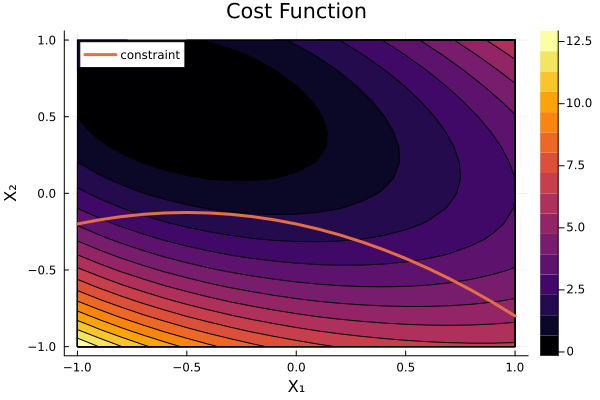

In [18]:
let
    Q = [1.65539  2.89376; 2.89376  6.51521];
    q = [2;-3]
    cost(x) = 0.5*x'*Q*x + q'*x + exp(-1.3*x[1] + 0.3*x[2]^2) # cost function 
    contour(-1:.1:1,-1:.1:1, (x1,x2)-> cost([x1;x2]),title = "Cost Function",
            xlabel = "X₁", ylabel = "X₂",fill = true)
        plot!(-1:.1:1, -0.3*(-1:.1:1).^2 - 0.3*(-1:.1:1) .- .2,lw = 3,label = "constraint")
end

In [27]:
Q = [1.65539  2.89376; 2.89376  6.51521];
q = [2;-3]
cost(_x)=0.5*_x'*Q*_x + q'*_x 
x=[1,2]
c = FD.gradient(cost,x)
@show c

h=FD.jacobian(cost,x)
@show h



c = [8.266621356553252, 14.00998490164315]


LoadError: DimensionMismatch("jacobian(f, x) expects that f(x) is an array. Perhaps you meant gradient(f, x)?")

In [21]:
# we will use Newton's method to solve the constrained optimization problem shown above
function cost(x::Vector)
    Q = [1.65539  2.89376; 2.89376  6.51521];
    q = [2;-3]
    return 0.5*x'*Q*x + q'*x + exp(-1.3*x[1] + 0.3*x[2]^2)
end
function constraint(x::Vector)
    norm(x) - 0.5 
end
# HINT: use this if you want to, but you don't have to
function constraint_jacobian(x::Vector)::Matrix
    # since `constraint` returns a scalar value, ForwardDiff 
    # will only allow us to compute a gradient of this function 
    # (instead of a Jacobian). This means we have two options for
    # computing the Jacobian: Option 1 is to just reshape the gradient
    # into a row vector
    
    # J = reshape(FD.gradient(constraint, x), 1, 2)
    
    # or we can just make the output of constraint an array, 
    constraint_array(_x) = [constraint(_x)]
    J = FD.jacobian(constraint_array, x)
    
    # assert the jacobian has # rows = # outputs 
    # and # columns = # inputs 
    @assert size(J) == (length(constraint(x)), length(x))
    
    return J 
end
function kkt_conditions(z::Vector)::Vector
    # TODO: return the KKT conditions

    x = z[1:2]
    λ = z[3:3]

    # TODO: return the stationarity condition for the cost function
    # and the primal feasibility
    Δf=FD.gradient(cost,x)+transpose(constraint_jacobian(x))*λ
    @show FD.gradient(cost,x)
    @show  FD.jacobian(cost,x)
    [Δf;constraint(x)]
end

function fn_kkt_jac(z::Vector)::Matrix
    # TODO: return full Newton Jacobian of kkt conditions wrt z
    x = z[1:2]
    λ = z[3]
    
    lag(_x)=cost(_x)+λ*constraint(_x)
    A=transpose(FD.gradient(constraint,x))
    H=FD.hessian(lag,x)
    ρ=1e-3
    return [H+ρ*I A';A -ρ*I]
    
 
    
end
function gn_kkt_jac(z::Vector)::Matrix
    # TODO: return Gauss-Newton Jacobian of kkt conditions wrt z 
    x = z[1:2]
    λ = z[3]

    # TODO: return Gauss-Newton jacobian with a 1e-3 regularizer
    A = transpose(FD.gradient(constraint, x))
    H=FD.hessian(cost, x)
    ρ = 1e-3
    return [H+ρ*I A'; A -ρ*I]
end

gn_kkt_jac (generic function with 1 method)

In [22]:
@testset "Test Jacobians" begin 
    
    # first we check the regularizer 
    z = randn(3)
    J_fn = fn_kkt_jac(z)
    J_gn = gn_kkt_jac(z)
    
    # check what should/shouldn't be the same between 
    @test norm(J_fn[1:2,1:2] - J_gn[1:2,1:2]) > 1e-10
    @test abs(J_fn[3,3] + 1e-3) < 1e-10
    @test abs(J_gn[3,3] + 1e-3) < 1e-10
    @test norm(J_fn[1:2,3] - J_gn[1:2,3]) < 1e-10
    @test norm(J_fn[3,1:2] - J_gn[3,1:2]) < 1e-10
end

Test Summary:  | Pass  Total
Test Jacobians |    5      5


Test.DefaultTestSet("Test Jacobians", Any[], 5, false, false)

In [23]:
@testset "Full Newton" begin 
    
    
    z0 = [-.1, .5, 0] # initial guess
    merit_fx(_z) = norm(kkt_conditions(_z)) # simple merit function
    Z = newtons_method(z0, kkt_conditions, fn_kkt_jac, merit_fx; tol = 1e-4, max_iters = 100, verbose = true)
    R = kkt_conditions.(Z)

    # make sure we converged on a solution to the KKT conditions 
    @test norm(kkt_conditions(Z[end])) < 1e-4
    @test length(R) < 6
    
    
    # ------------------------plotting stuff------------------------
    Rp = [[abs(R[i][ii]) + 1e-15 for i = 1:length(R)] for ii = 1:length(R[1])] # this gets abs of each term at each iteration
    
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Full Newton on KKT Conditions",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
    display(plot!(Rp[3],label = "|r_3|"))
    
    contour(-.6:.1:0,0:.1:.6, (x1,x2)-> cost([x1;x2]),title = "Cost Function",
            xlabel = "X₁", ylabel = "X₂",fill = true)
    xcirc = [.5*cos(θ) for θ in range(0, 2*pi, length = 200)]
    ycirc = [.5*sin(θ) for θ in range(0, 2*pi, length = 200)]
    plot!(xcirc,ycirc, lw = 3.0, xlim = (-.6, 0), ylim = (0, .6),label = "constraint")
    z1_hist = [z[1] for z in Z]
    z2_hist = [z[2] for z in Z]
    display(plot!(z1_hist, z2_hist, marker = :d, label = "xₖ"))
    # ------------------------plotting stuff------------------------
end

FD.gradient(cost, x) = [1.6855584155478687, 0.3364865194889533]
Full Newton: Error During Test at In[23]:1
  Got exception outside of a @test
  DimensionMismatch("jacobian(f, x) expects that f(x) is an array. Perhaps you meant gradient(f, x)?")
  Stacktrace:
    [1] vector_mode_jacobian(f::typeof(cost), x::Vector{Float64}, cfg::ForwardDiff.JacobianConfig{ForwardDiff.Tag{typeof(cost), Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{typeof(cost), Float64}, Float64, 2}}})
      @ ForwardDiff ~/.julia/packages/ForwardDiff/vXysl/src/jacobian.jl:126
    [2] jacobian(f::Function, x::Vector{Float64}, cfg::ForwardDiff.JacobianConfig{ForwardDiff.Tag{typeof(cost), Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{typeof(cost), Float64}, Float64, 2}}}, ::Val{true})
      @ ForwardDiff ~/.julia/packages/ForwardDiff/vXysl/src/jacobian.jl:21
    [3] jacobian(f::Function, x::Vector{Float64}, cfg::ForwardDiff.JacobianConfig{ForwardDiff.Tag{typeof(cost), Float64}, Float64, 2, V

LoadError: [91mSome tests did not pass: 0 passed, 0 failed, 1 errored, 0 broken.[39m

In [ ]:
@testset "Gauss-Newton" begin 
    
    
    z0 = [-.1, .5, 0] # initial guess
    merit_fx(_z) = norm(kkt_conditions(_z)) # simple merit function
    
    # the only difference in this block vs the previous is `gn_kkt_jac` instead of `fn_kkt_jac`
    Z = newtons_method(z0, kkt_conditions, gn_kkt_jac, merit_fx; tol = 1e-4, max_iters = 100, verbose = true)
    R = kkt_conditions.(Z)

    # make sure we converged on a solution to the KKT conditions 
    @test norm(kkt_conditions(Z[end])) < 1e-4
    @test length(R) < 10
    
    
    # ------------------------plotting stuff------------------------
    Rp = [[abs(R[i][ii]) + 1e-15 for i = 1:length(R)] for ii = 1:length(R[1])] # this gets abs of each term at each iteration
    
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Full Newton on KKT Conditions",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
    display(plot!(Rp[3],label = "|r_3|"))
    
    contour(-.6:.1:0,0:.1:.6, (x1,x2)-> cost([x1;x2]),title = "Cost Function",
            xlabel = "X₁", ylabel = "X₂",fill = true)
    xcirc = [.5*cos(θ) for θ in range(0, 2*pi, length = 200)]
    ycirc = [.5*sin(θ) for θ in range(0, 2*pi, length = 200)]
    plot!(xcirc,ycirc, lw = 3.0, xlim = (-.6, 0), ylim = (0, .6),label = "constraint")
    z1_hist = [z[1] for z in Z]
    z2_hist = [z[2] for z in Z]
    display(plot!(z1_hist, z2_hist, marker = :d, label = "xₖ"))
    # ------------------------plotting stuff------------------------
end

## Part B (10 pts): Balance a quadruped
Now we are going to solve for the control input $u \in \mathbb{R}^{12}$, and state $x \in \mathbb{R}^{30}$, such that the quadruped is balancing up on one leg. First, let's load in a model and display the rough "guess" configuration that we are going for:

In [ ]:
include(joinpath(@__DIR__, "quadruped.jl"))

# --------these three are global variables------------
model = UnitreeA1()
mvis = initialize_visualizer(model)
const x_guess = initial_state(model)
# ----------------------------------------------------

set_configuration!(mvis, x_guess[1:state_dim(model)÷2])
render(mvis)

Now, we are going to solve for the state and control that get us a statically stable stance on just one leg. We are going to do this by solving the following optimization problem:

$$ \begin{align} \min_{x,u} \quad & \frac{1}{2}(x - x_{guess})^T(x - x_{guess}) + \frac{1}{2}10^{-3} u^Tu \\ 
 \mbox{st} \quad & f(x,u) = 0 
 \end{align}$$
 
 Where our primal variables are $x \in \mathbb{R}^{30}$ and $u \in \mathbb{R}^{12}$, that we can stack up in a new variable $y = [x^T, u^T]^T \in \mathbb{R}^{42}$. We have a constraint $f(x,u) = \dot{x} = 0$, which will ensure the resulting configuration is stable. This constraint is enforced with a dual variable $\lambda \in \mathbb{R}^{30}$. We are now ready to use Newton's method to solve this equality constrained optimization problem, where we will solve for a variable $z = [y^T, \lambda^T]^T \in \mathbb{R}^{72}$.
 
 In this next section, you should fill out `quadruped_kkt(z)` with the KKT conditions for this optimization problem, given the constraint is that `dynamics(model, x, u) = zeros(30)`. When forming the Jacobian of the KKT conditions, use the Gauss-Newton approximation for the hessian of the Lagrangian (see example above if you're having trouble with this).

In [ ]:
# initial guess 
const x_guess = initial_state(model)

# indexing stuff 
const idx_x = 1:30 
const idx_u = 31:42
const idx_c = 43:72

# I like stacking up all the primal variables in y, where y = [x;u]
# Newton's method will solve for z = [x;u;λ], or z = [y;λ]

function quadruped_cost(y::Vector)
    # cost function 
    @assert length(y) == 42
    x = y[idx_x]
    u = y[idx_u]
    
    # TODO: return cost 
    error("quadruped cost not implemented")
    return 0.0
end
function quadruped_constraint(y::Vector)::Vector
    # constraint function 
    @assert length(y) == 42
    x = y[idx_x]
    u = y[idx_u]
    
    # TODO: return constraint
    error("quadruped constraint not implemented")
    return 0*y
end
function quadruped_kkt(z::Vector)::Vector
    @assert length(z) == 72 
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    
    # TODO: return the KKT conditions 
    error("quadruped kkt not implemented")
    return 0*z
end

function quadruped_kkt_jac(z::Vector)::Matrix
    @assert length(z) == 72 
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    
    # TODO: return Gauss-Newton Jacobian with a regularizer (try 1e-3,1e-4,1e-5,1e-6)
    error("quadruped kkt jac not implemented")
    return zeros(length(z), length(z))
end

In [ ]:
function quadruped_merit(z)
    # merit function for the quadruped problem 
    @assert length(z) == 72 
    r = quadruped_kkt(z)
    return norm(r[1:42]) + 1e4*norm(r[43:end])
end

@testset "quadruped standing" begin
    
    z0 = [x_guess; zeros(12); zeros(30)]
    Z = newtons_method(z0, quadruped_kkt, quadruped_kkt_jac, quadruped_merit; tol = 1e-6, verbose = true, max_iters = 50)
    set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
    R = norm.(quadruped_kkt.(Z))
    
    display(plot(1:length(R), R, yaxis=:log,xlabel = "iteration", ylabel = "|r|"))
    
    @test R[end] < 1e-6
    @test length(Z) < 25
    
    x,u = Z[end][idx_x], Z[end][idx_u]
    
    @test norm(dynamics(model, x, u)) < 1e-6
    
end

In [ ]:
let
    
    # let's visualize the balancing position we found
    
    z0 = [x_guess; zeros(12); zeros(30)]
    Z = newtons_method(z0, quadruped_kkt, quadruped_kkt_jac, quadruped_merit; tol = 1e-6, verbose = false, max_iters = 50)
    # visualizer 
    mvis = initialize_visualizer(model)
    set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
    render(mvis)
    
    
end